##### Import packages

In [21]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import accuracy_score,recall_score,precision_score
from sklearn.metrics import f1_score,roc_auc_score, roc_curve, auc
from scipy.stats import chi2_contingency
from sklearn.feature_selection import mutual_info_classif
from imblearn.over_sampling import SMOTE
import warnings

warnings.filterwarnings("ignore")

In [2]:
df_train = pd.read_csv("./data/churn-bigml-80.csv")
df_test = pd.read_csv("./data/churn-bigml-20.csv")

In [3]:
df_train.shape, df_test.shape

((2666, 20), (667, 20))

##### Output Labels distribution

In [4]:
df_train["Churn"].value_counts() / df_train["Churn"].value_counts().sum()*100 

Churn
False    85.446362
True     14.553638
Name: count, dtype: float64

In [5]:
df_test["Churn"].value_counts() / df_test["Churn"].value_counts().sum()*100

Churn
False    85.757121
True     14.242879
Name: count, dtype: float64

##### Merge both data to get distribution

In [6]:
df_orig = pd.concat([df_train, df_test])

In [7]:
df_orig.shape

(3333, 20)

In [8]:
df_orig.head()

State  Account length  Area code International plan Voice mail plan  \
0    KS             128        415                 No             Yes   
1    OH             107        415                 No             Yes   
2    NJ             137        415                 No              No   
3    OH              84        408                Yes              No   
4    OK              75        415                Yes              No   

   Number vmail messages  Total day minutes  Total day calls  \
0                     25              265.1              110   
1                     26              161.6              123   
2                      0              243.4              114   
3                      0              299.4               71   
4                      0              166.7              113   

   Total day charge  Total eve minutes  Total eve calls  Total eve charge  \
0             45.07              197.4               99             16.78   
1             27.47              195.5              103             16.62   
2             41.38              121.2              110             10.30   
3             50.90               61.9               88              5.26   
4             28.34              148.3              122             12.61   

   Total night minutes  Total night calls  Total night charge  \
0                244.7                 91               11.01   
1                254.4                103               11.45   
2                162.6                104                7.32   
3                196.9                 89                8.86   
4                186.9                121                8.41   

   Total intl minutes  Total intl calls  Total intl charge  \
0                10.0                 3               2.70   
1                13.7                 3               3.70   
2                12.2                 5               3.29   
3                 6.6                 7               1.78   
4                10.1                 3               2.73   

   Customer service calls  Churn  
0                       1  False  
1                       1  False  
2                       0  False  
3                       2  False  
4                       3  False

In [9]:
df_orig.describe()

Account length    Area code  Number vmail messages  Total day minutes  \
count     3333.000000  3333.000000            3333.000000        3333.000000   
mean       101.064806   437.182418               8.099010         179.775098   
std         39.822106    42.371290              13.688365          54.467389   
min          1.000000   408.000000               0.000000           0.000000   
25%         74.000000   408.000000               0.000000         143.700000   
50%        101.000000   415.000000               0.000000         179.400000   
75%        127.000000   510.000000              20.000000         216.400000   
max        243.000000   510.000000              51.000000         350.800000   

       Total day calls  Total day charge  Total eve minutes  Total eve calls  \
count      3333.000000       3333.000000        3333.000000      3333.000000   
mean        100.435644         30.562307         200.980348       100.114311   
std          20.069084          9.259435          50.713844        19.922625   
min           0.000000          0.000000           0.000000         0.000000   
25%          87.000000         24.430000         166.600000        87.000000   
50%         101.000000         30.500000         201.400000       100.000000   
75%         114.000000         36.790000         235.300000       114.000000   
max         165.000000         59.640000         363.700000       170.000000   

       Total eve charge  Total night minutes  Total night calls  \
count       3333.000000          3333.000000        3333.000000   
mean          17.083540           200.872037         100.107711   
std            4.310668            50.573847          19.568609   
min            0.000000            23.200000          33.000000   
25%           14.160000           167.000000          87.000000   
50%           17.120000           201.200000         100.000000   
75%           20.000000           235.300000         113.000000   
max           30.910000           395.000000         175.000000   

       Total night charge  Total intl minutes  Total intl calls  \
count         3333.000000         3333.000000       3333.000000   
mean             9.039325           10.237294          4.479448   
std              2.275873            2.791840          2.461214   
min              1.040000            0.000000          0.000000   
25%              7.520000            8.500000          3.000000   
50%              9.050000           10.300000          4.000000   
75%             10.590000           12.100000          6.000000   
max             17.770000           20.000000         20.000000   

       Total intl charge  Customer service calls  
count        3333.000000             3333.000000  
mean            2.764581                1.562856  
std             0.753773                1.315491  
min             0.000000                0.000000  
25%             2.300000                1.000000  
50%             2.780000                1.000000  
75%             3.270000                2.000000  
max             5.400000                9.000000

In [10]:
df_orig.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3333 entries, 0 to 666
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   State                   3333 non-null   object 
 1   Account length          3333 non-null   int64  
 2   Area code               3333 non-null   int64  
 3   International plan      3333 non-null   object 
 4   Voice mail plan         3333 non-null   object 
 5   Number vmail messages   3333 non-null   int64  
 6   Total day minutes       3333 non-null   float64
 7   Total day calls         3333 non-null   int64  
 8   Total day charge        3333 non-null   float64
 9   Total eve minutes       3333 non-null   float64
 10  Total eve calls         3333 non-null   int64  
 11  Total eve charge        3333 non-null   float64
 12  Total night minutes     3333 non-null   float64
 13  Total night calls       3333 non-null   int64  
 14  Total night charge      3333 non-null   float6

##### Null and Data Duplicate check

In [11]:
df_orig.isnull().sum()

State                     0
Account length            0
Area code                 0
International plan        0
Voice mail plan           0
Number vmail messages     0
Total day minutes         0
Total day calls           0
Total day charge          0
Total eve minutes         0
Total eve calls           0
Total eve charge          0
Total night minutes       0
Total night calls         0
Total night charge        0
Total intl minutes        0
Total intl calls          0
Total intl charge         0
Customer service calls    0
Churn                     0
dtype: int64

In [12]:
df_orig.duplicated().sum()

np.int64(0)

In [13]:
# data has no null values
# data has no duplicates

##### EDA ( Exploratory Data Analysis )

###### Convert categorical / Boolean features to numerical ( except 'State')

In [14]:
df_orig.dtypes

State                      object
Account length              int64
Area code                   int64
International plan         object
Voice mail plan            object
Number vmail messages       int64
Total day minutes         float64
Total day calls             int64
Total day charge          float64
Total eve minutes         float64
Total eve calls             int64
Total eve charge          float64
Total night minutes       float64
Total night calls           int64
Total night charge        float64
Total intl minutes        float64
Total intl calls            int64
Total intl charge         float64
Customer service calls      int64
Churn                        bool
dtype: object

In [15]:
cat_columns = [i for i in df_orig.dtypes[(df_orig.dtypes == 'object') | (df_orig.dtypes == 'bool') ].index.tolist() if i != "State"]
cat_columns

['International plan', 'Voice mail plan', 'Churn']

In [16]:
num_columns = [i for i in df_orig.dtypes[(df_orig.dtypes == 'float64') | (df_orig.dtypes == 'int64') ].index.tolist() ]
num_columns

['Account length',
 'Area code',
 'Number vmail messages',
 'Total day minutes',
 'Total day calls',
 'Total day charge',
 'Total eve minutes',
 'Total eve calls',
 'Total eve charge',
 'Total night minutes',
 'Total night calls',
 'Total night charge',
 'Total intl minutes',
 'Total intl calls',
 'Total intl charge',
 'Customer service calls']

In [17]:
# No need to apply label or one hot encoder since labels are binary: {Yes:1, No:0} and {True: 1, False 0}

In [18]:
df_orig["International plan"].replace({"Yes":1, "No":0},inplace=True )
df_orig["Voice mail plan"].replace({"Yes":1, "No":0},inplace=True )

df_orig["Churn"].replace({True:1, False:0},inplace=True )

C:\Users\Acer\AppData\Local\Temp\ipykernel_6888\3903635835.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_orig["International plan"].replace({"Yes":1, "No":0},inplace=True )
C:\Users\Acer\AppData\Local\Temp\ipykernel_6888\3903635835.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_orig

##### Visualiza the data

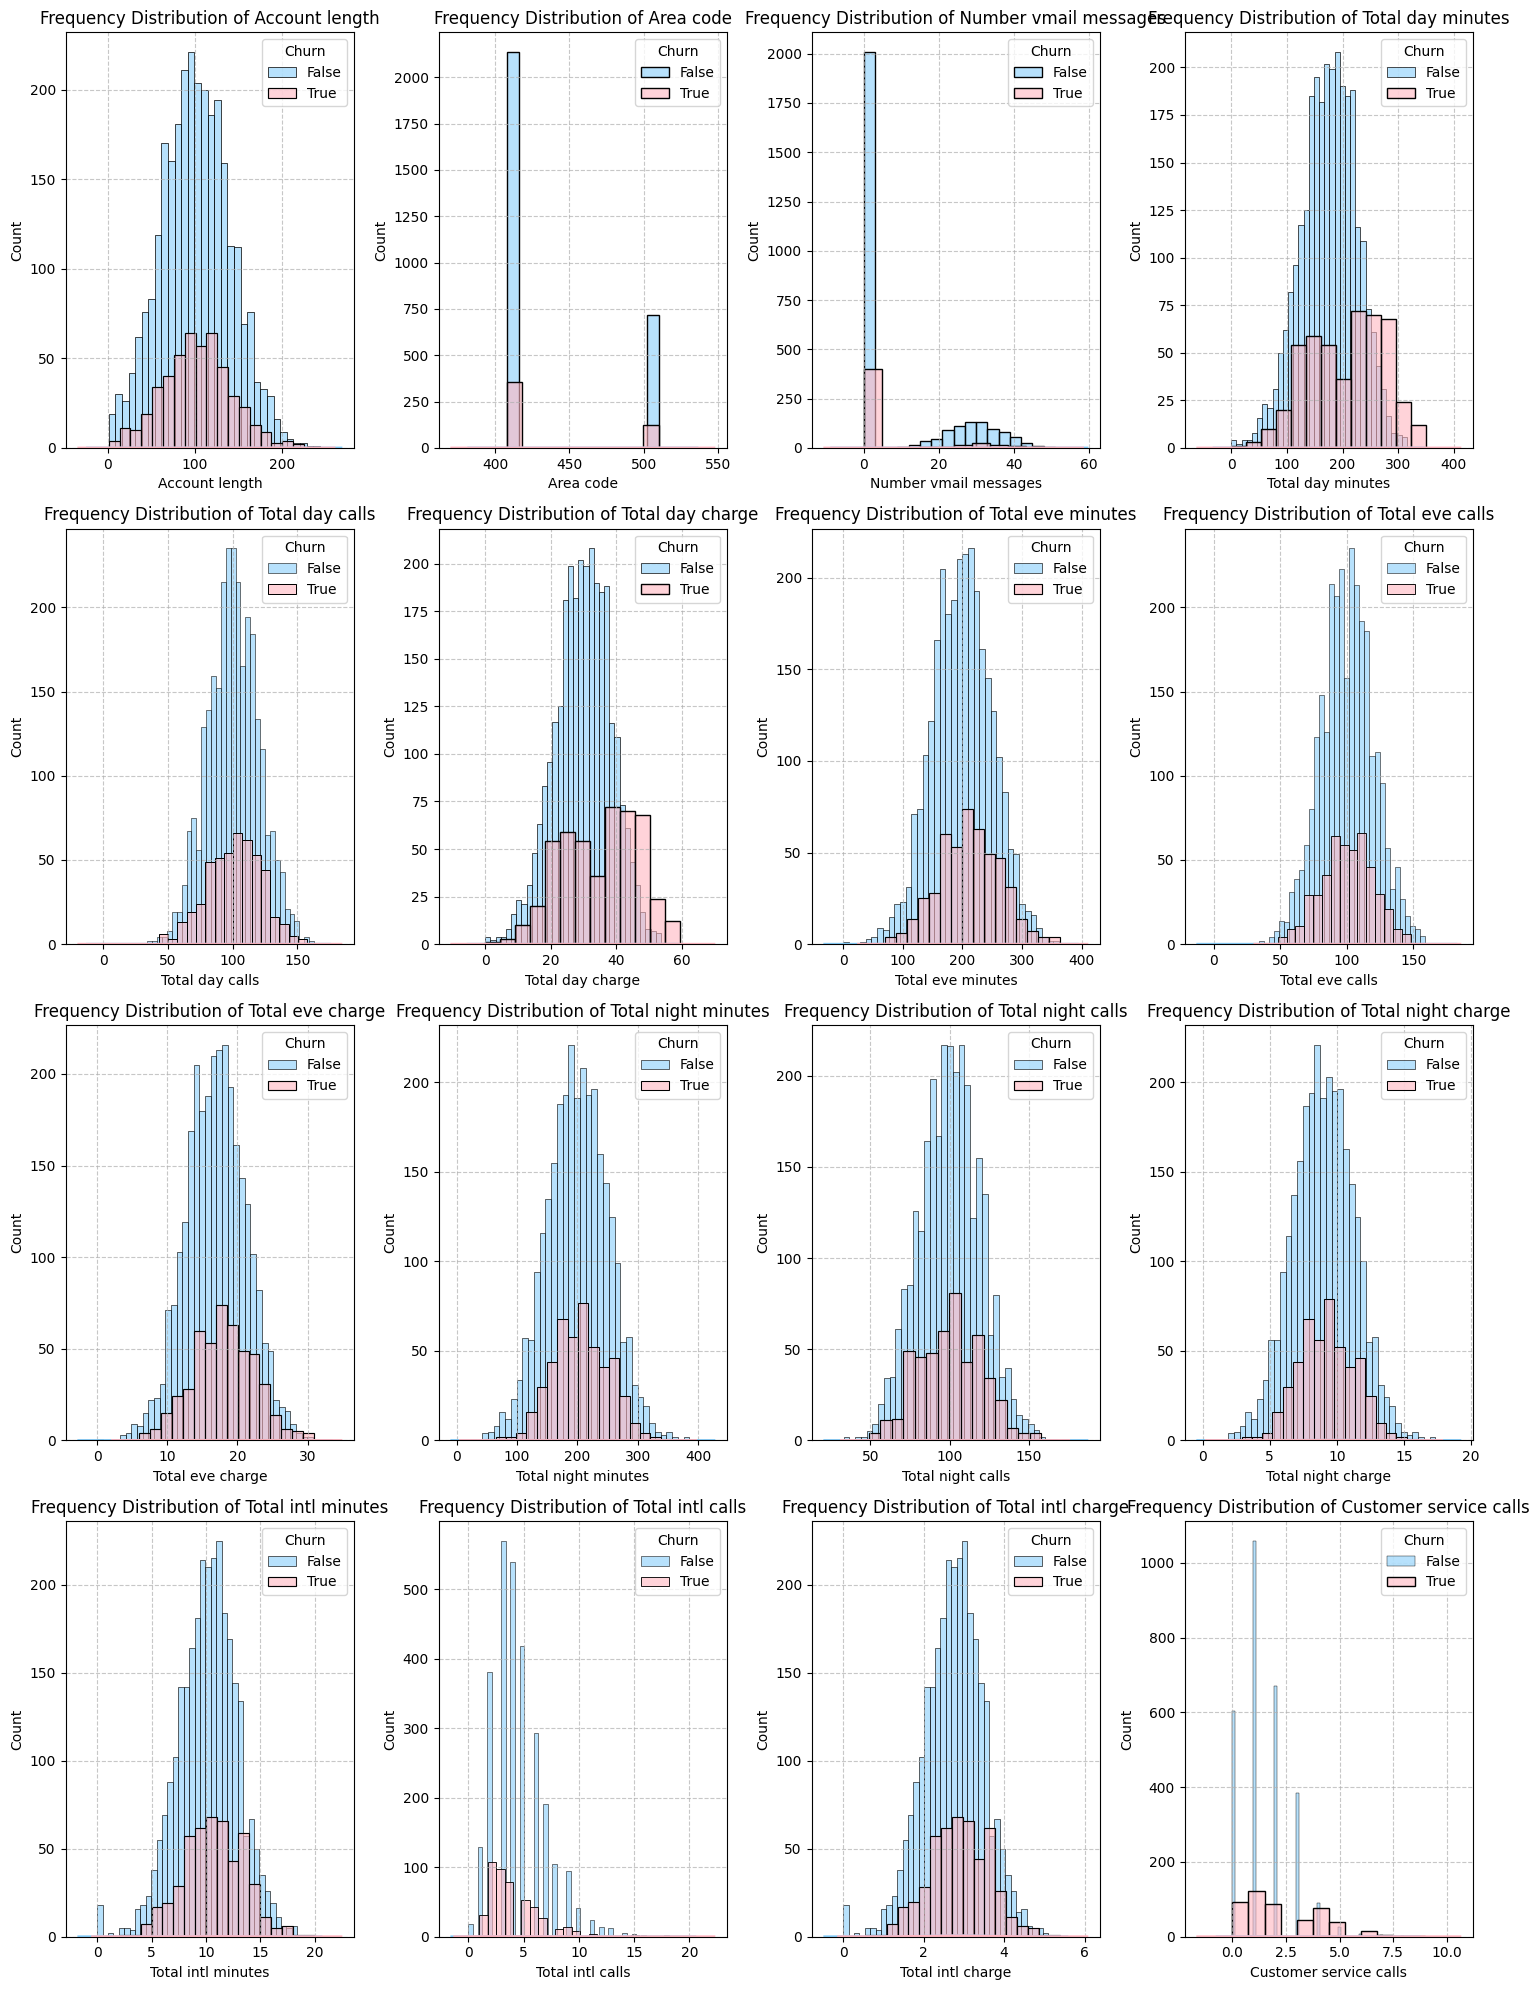

In [24]:
## create figure
n_cols = 4
n_rows = int(np.ceil(len(num_columns) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
axes = axes.ravel() 

# define colors for each class
colors = ['#87CEFA', '#FFB6C1']

# create histograms for each numerical column
for idx, col in enumerate(num_columns):
    # Create histogram with density plot
    sns.histplot(data=df_orig[df_orig['Churn'] == 0], x=col, 
                label='False', color=colors[0], 
                stat='count', alpha=0.6,
                ax=axes[idx])
    
    sns.histplot(data=df_orig[df_orig['Churn'] == 1], x=col, 
                label='True', color=colors[1], 
                stat='count', alpha=0.6,
                ax=axes[idx] )
    
    # Add density curves
    sns.kdeplot(data=df_orig[df_orig['Churn'] == 0], x=col, 
                color=colors[0], linewidth=2,
                ax=axes[idx])
    sns.kdeplot(data=df_orig[df_orig['Churn'] == 1], x=col, 
                color=colors[1], linewidth=2,
                ax=axes[idx])
    
    axes[idx].set_title(f'Frequency Distribution of {col}')
    axes[idx].legend(title='Churn')
    axes[idx].grid(True, linestyle='--', alpha=0.7)
    

plt.tight_layout()
plt.show()

##### Check for Data imbalance

In [27]:
df_orig["Churn"].value_counts()*100/df_orig["Churn"].value_counts().sum()

Churn
0    85.508551
1    14.491449
Name: count, dtype: float64

In [28]:
# Data imbalance exist between Churn_True and Churn_False labels of the data

##### Correlation check

<Axes: >

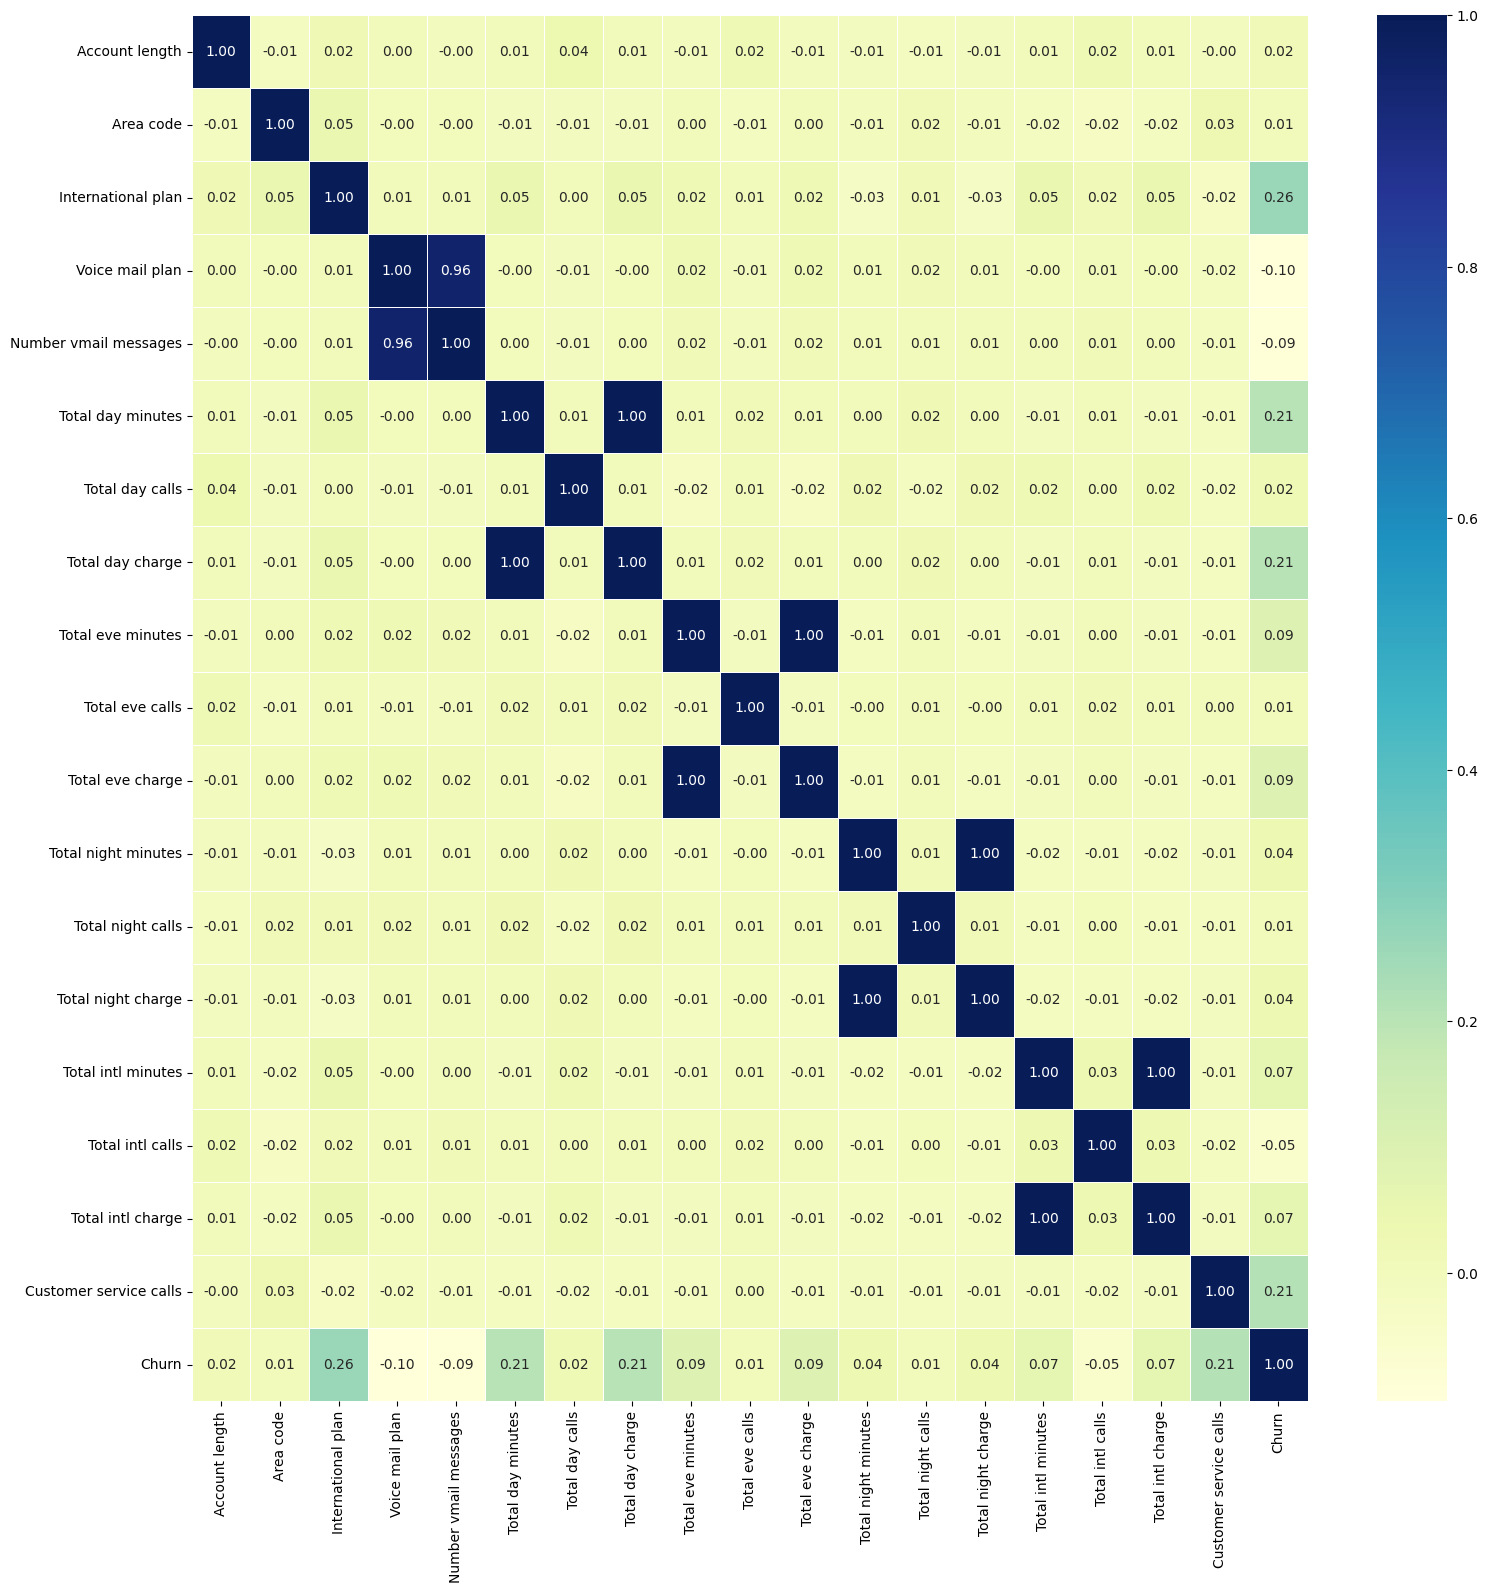

In [29]:
# plot correlations 
plt.figure(figsize=(18,18))
sns.heatmap(df_orig.corr(numeric_only=True),annot=True,cmap="YlGnBu",fmt=".2f",linewidths=0.5)

In [30]:
#  Very High Correlation exist between columns like (0.96, 1.0, etc)

##### Mutual Information (MI) Scores¶
Calculate Mutual Information (MI) scores to assess the relevance of each feature with respect to the target variable 'Churn'

In [33]:
# get numeric columns
numerical_columns = df_orig.select_dtypes(include=['number']).columns

# compute mutual information
mi = mutual_info_classif(df_orig[numerical_columns].drop('Churn', axis=1), df_orig['Churn'], random_state=42)

# create a dataframe to display MI scores
mi_scores = pd.DataFrame({'Feature': numerical_columns.drop('Churn'), 'MI Score': mi})
mi_scores = mi_scores.sort_values(by='MI Score', ascending=False)


print(mi_scores)

                   Feature  MI Score
5        Total day minutes  0.054738
7         Total day charge  0.054674
17  Customer service calls  0.039978
2       International plan  0.023280
3          Voice mail plan  0.011336
4    Number vmail messages  0.011022
1                Area code  0.010929
0           Account length  0.009904
14      Total intl minutes  0.006956
6          Total day calls  0.006861
11     Total night minutes  0.005224
16       Total intl charge  0.002751
9          Total eve calls  0.001176
13      Total night charge  0.000717
15        Total intl calls  0.000185
8        Total eve minutes  0.000000
12       Total night calls  0.000000
10        Total eve charge  0.000000


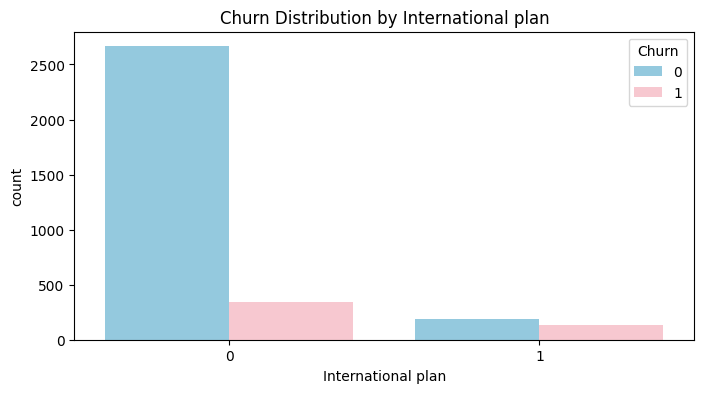

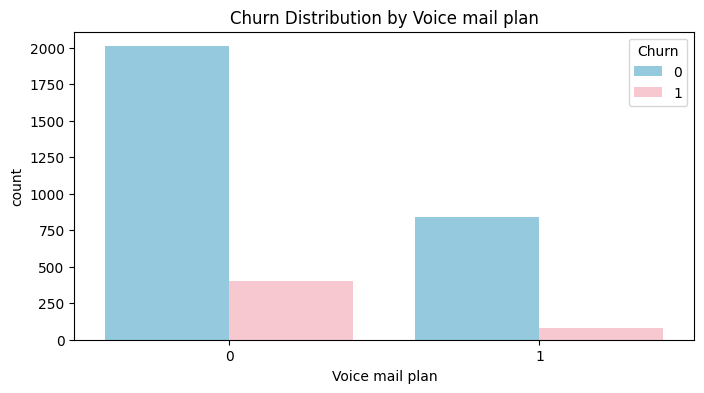

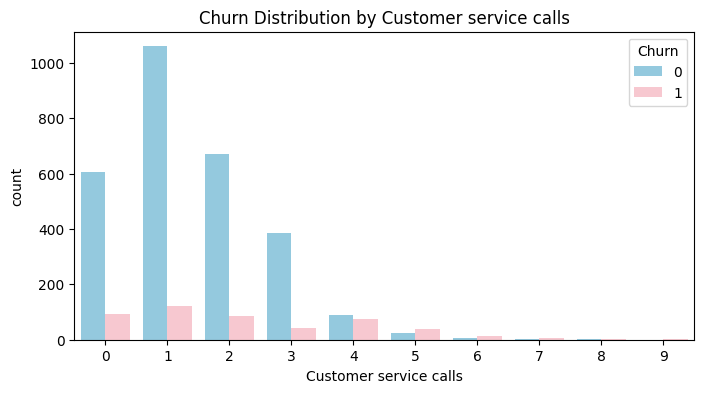

In [35]:
sns.set_palette(['skyblue', 'pink'])

features = ['International plan', 'Voice mail plan','Customer service calls']

for feature in features:
    plt.figure(figsize=(8, 4))  
    sns.countplot(x=feature, hue='Churn', data=df_orig)
    plt.title(f"Churn Distribution by {feature}")
    plt.show()

##### Mean churn value by features

In [37]:
# calculate mean values for churned and not churned customers
Churned = df_orig[df_orig['Churn'] == 1].describe().T
Not_Churned = df_orig[df_orig['Churn'] == 0].describe().T

# Calculate the absolute difference in means between the two groups 
diff_means = abs(Churned['mean'] - Not_Churned['mean'])

In [39]:
# sorth them based on the absolute difference
Churned = Churned.loc[diff_means.sort_values(ascending=False).index]
Not_Churned = Not_Churned.loc[diff_means.sort_values(ascending=False).index]


In [41]:
Churned["mean"]

Total day minutes         206.914079
Total eve minutes         212.410145
Total day charge           35.175921
Total night minutes       205.231677
Number vmail messages       5.115942
Account length            102.664596
Total eve charge           18.054969
Total day calls           101.335404
Churn                       1.000000
Customer service calls      2.229814
Area code                 437.817805
Total intl minutes         10.700000
Total eve calls           100.561077
Total intl calls            4.163561
Total night calls         100.399586
Total night charge          9.235528
International plan          0.283644
Total intl charge           2.889545
Voice mail plan             0.165631
Name: mean, dtype: float64

In [42]:
Not_Churned["mean"]

Total day minutes         175.175754
Total eve minutes         199.043298
Total day charge           29.780421
Total night minutes       200.133193
Number vmail messages       8.604561
Account length            100.793684
Total eve charge           16.918909
Total day calls           100.283158
Churn                       0.000000
Customer service calls      1.449825
Area code                 437.074737
Total intl minutes         10.158877
Total eve calls           100.038596
Total intl calls            4.532982
Total night calls         100.058246
Total night charge          9.006074
International plan          0.065263
Total intl charge           2.743404
Voice mail plan             0.295439
Name: mean, dtype: float64

In [43]:
diff_means

Account length             1.870912
Area code                  0.743069
International plan         0.218381
Voice mail plan            0.129807
Number vmail messages      3.488619
Total day minutes         31.738324
Total day calls            1.052246
Total day charge           5.395500
Total eve minutes         13.366847
Total eve calls            0.522480
Total eve charge           1.136060
Total night minutes        5.098484
Total night calls          0.341340
Total night charge         0.229454
Total intl minutes         0.541123
Total intl calls           0.369421
Total intl charge          0.146141
Customer service calls     0.779989
Churn                      1.000000
Name: mean, dtype: float64

##### Outlier check using IQR ( Box plots)

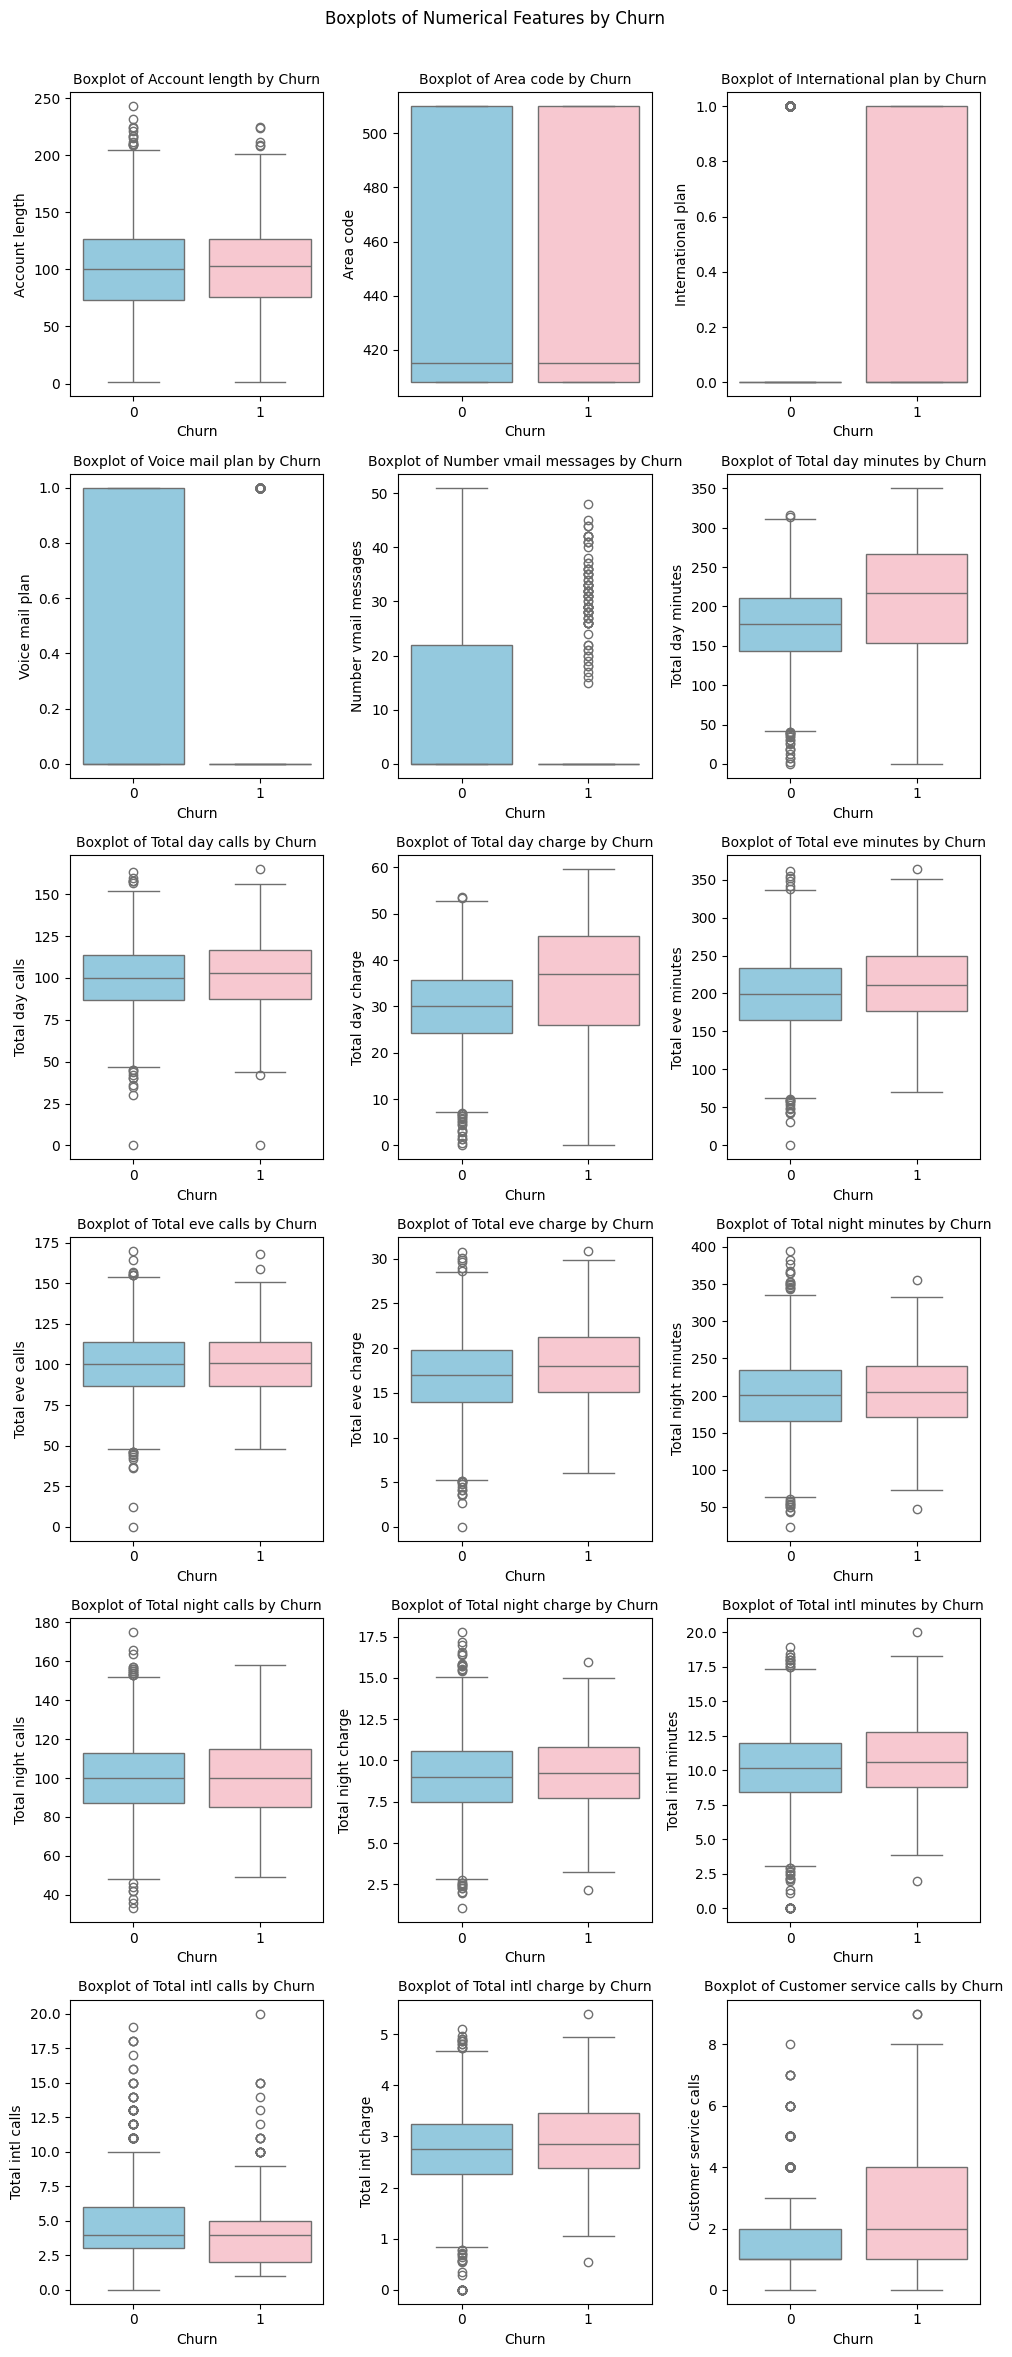

In [44]:
# features to plot
features = numerical_columns.drop('Churn')

# columns and rows needed
num_features = len(features)
num_cols = 3
num_rows = math.ceil(num_features / num_cols)

# subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, num_rows * 4))


axes = axes.flatten()
# iterate through features and create boxplots
for i, feature in enumerate(features):
    sns.boxplot(x='Churn', y=feature, data=df_orig, ax=axes[i], palette=['skyblue', 'pink'])
    axes[i].set_title(f'Boxplot of {feature} by Churn', fontsize=10)
    axes[i].set_xlabel('Churn', fontsize=10)
    axes[i].set_ylabel(feature, fontsize=10)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0, 1, 0.96])

fig.suptitle('Boxplots of Numerical Features by Churn', fontsize=12)

plt.show()